# Example 3 Darcy inverse interface coefficient identification

In [1]:
import sys
sys.path.append("../")
from libs import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load the evaluation data
The test data will have the normalizer based on the train data applied. Moreover, we generate data with 5% noises.

In [2]:
noise = 5e-2
subsample_nodes = 2
subsample_attn = 6
train_path = os.path.join(DATA_PATH, 'piececonst_r421_N1024_smooth1.mat')
test_path = os.path.join(DATA_PATH, 'piececonst_r421_N1024_smooth2.mat')
train_dataset = DarcyDataset(data_path=train_path,
                             subsample_attn=subsample_attn,
                             subsample_nodes=subsample_nodes,
                             subsample_inverse=subsample_attn,
                             subsample_method='average',
                             inverse_problem=True,
                             return_boundary=True,
                             return_edge=False,
                             train_data=True,
                             noise=noise,
                             train_len=1)

valid_dataset = DarcyDataset(data_path=test_path,
                             normalizer_x=train_dataset.normalizer_x,
                             subsample_attn=subsample_attn,
                             subsample_nodes=subsample_nodes,
                             subsample_inverse=subsample_attn,
                             subsample_method='average',
                             inverse_problem=True,
                             return_boundary=True,
                             return_edge=False,
                             train_data=False,
                             noise=noise,
                             valid_len=100)

valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, drop_last=False,
                          pin_memory=True)

Loading piececonst_r421_N1024_smooth1.mat: start at 1626964254.51;
LOCAL RAM USAGE AT START: 1.11 GB
Loading piececonst_r421_N1024_smooth1.mat: done at 1626964267.56 (13.055531 secs elapsed);
LOCAL RAM USAGE AT END: 2.64GB (+1.54GB)


Loading piececonst_r421_N1024_smooth2.mat: start at 1626964274.33;
LOCAL RAM USAGE AT START: 1.84 GB
Loading piececonst_r421_N1024_smooth2.mat: done at 1626964286.87 (12.540523 secs elapsed);
LOCAL RAM USAGE AT END: 3.36GB (+1.52GB)




# Set up the model

In [3]:
n_grid = int(((421 - 1)/subsample_nodes) + 1)
n_grid_c = int(((421 - 1)/subsample_attn) + 1)
downsample, _ = DarcyDataset.get_scaler_sizes(n_grid, n_grid_c)

with open(os.path.join(SRC_ROOT, 'config.yml')) as f:
    config = yaml.full_load(f)

config = config['ex3_darcy_inv']
config['normalizer'] = train_dataset.normalizer_y.to(device)
config['downscaler_size'] = downsample
config['upscaler_size'] = (n_grid_c, n_grid_c), (n_grid_c, n_grid_c)

torch.cuda.empty_cache()
model = FourierTransformer2D(**config)
model = model.to(device)

In [6]:
model.encoder_layers[0].attn

SimpleAttention(
  (linears): ModuleList(
    (0): Linear(in_features=192, out_features=192, bias=True)
    (1): Linear(in_features=192, out_features=192, bias=True)
    (2): Linear(in_features=192, out_features=192, bias=True)
  )
  (norm_K): ModuleList(
    (0): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (1): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (2): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (3): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
  )
  (norm_V): ModuleList(
    (0): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (1): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (2): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
    (3): LayerNorm((48,), eps=1e-07, elementwise_affine=True)
  )
  (fc): Linear(in_features=200, out_features=192, bias=True)
  (dropout): Dropout(p=0.05, inplace=False)
)

# Set up the evaluation metric
We load a model that is trained with 5% noises added.

Caveat: due to `nn.functional.interpolate` is used, we may get slightly different result than the ones in paper using even the same seed. See the Note in https://pytorch.org/docs/master/generated/torch.nn.functional.interpolate.html

In [5]:
h = 1/n_grid_c
metric_func = WeightedL2Loss2d(regularizer=False, h=h)

model = torch.load(os.path.join(MODEL_PATH, 'darcy_inv_71_6gt_192d_qkv_4h_n0.05_2021-06-03_paper.pt'))
model.eval()
val_metric = validate_epoch_darcy(model, metric_func, valid_loader, device)
print(f"\nModel's validation metric: {val_metric}")


Model's validation metric: {'metric': 0.058731779754161835}


# Let us plot some sample evaluations!

The evaluation sample used in the paper.

In [6]:
sample = next(iter(valid_loader))
coeff = sample['coeff']
u = sample['node']
pos = sample['pos']
a = sample['target']
grid = sample['grid']

with torch.no_grad():
    model.eval()
    out_ = model(u.to(device), None, pos.to(device), grid.to(device))
    preds = out_['preds']

# This is the input of the model

In [8]:
idx = 2
z_true = train_dataset.normalizer_x.inverse_transform(u)
z_true = z_true[idx, ..., 0].numpy()

_ = showcontour(z_true, width=350, height=350,)

# Ground truth coefficient 
- Full resolution and no noise

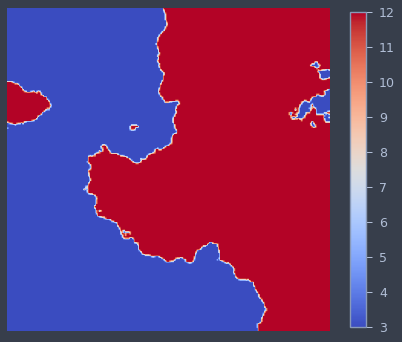

In [10]:
ah = coeff[idx,...,0].numpy()
fig, ax = plt.subplots(figsize=(6, 6))
a_plot = ax.imshow(ah, cmap='coolwarm')
cbar = fig.colorbar(a_plot, ax=ax, anchor=(0, 0.3), shrink=0.78)
plt.axis('off')
fig.tight_layout()

# This is the model's inference

- Reconstruction on the coarse grid

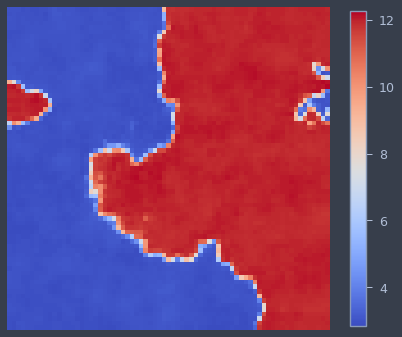

In [11]:
ah_preds = preds[idx, ..., 0].cpu().numpy()
fig, ax = plt.subplots(figsize=(6, 6))
pred_plot = ax.imshow(ah_preds, cmap='coolwarm')
cbar = fig.colorbar(pred_plot, ax=ax, anchor=(0, 0.3), shrink=0.78)
plt.axis('off')
fig.tight_layout()

In [13]:
print("Relative error: ", np.linalg.norm(ah[::3,::3]-ah_preds)/np.linalg.norm(ah))

Relative error:  0.023926813
